In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
from scipy.special import rel_entr
from scipy.stats import entropy
import scipy
from optimparallel import minimize_parallel

In [2]:
config = {
    'nbase': 500,
    'neca': 2000,
    'nwaypoints': 20,
    'optimizeon': 'entropy'
}

# Toy Datasets

In [3]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000
pcond1 = 0.3
pcat1 = 0.5

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 25000]]


np.random.seed(42)
x = np.random.multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

cond1 = np.random.binomial(1, pcond1, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, pcat1, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cat1), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [4]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4800
pcond1 = 0.5
pcat1 = 0.7
factor = 1.5

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]


x = np.random.multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = factor*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

cond1 = np.random.binomial(1, pcond1, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, pcat1, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cat1), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [5]:
# Define Cohen's d: Standardized Mean Difference
def cohensd(d1, d2):
    num = np.mean(d1) - np.mean(d2)
    den = np.sqrt((np.std(d1) ** 2 + np.std(d2) ** 2) / 2)
    cohens_d = num / den
    return cohens_d

In [6]:
# Plot data distribution
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', bins= 20, linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, bins= 20, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(col)
    return 

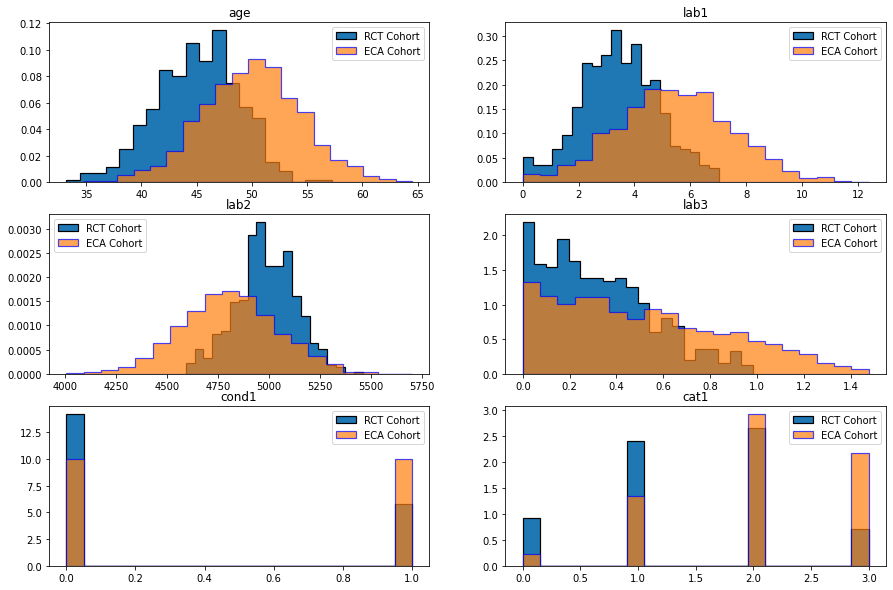

In [7]:
# View the Starting distribution

_, ax = plt.subplots(3,2, figsize=(15, 10))

data_base.name = 'RCT Cohort'
data_eca.name = 'ECA Cohort'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])
plot_dist(data_base, data_eca, 'cond1', ax[2][0])
plot_dist(data_base, data_eca, 'cat1', ax[2][1])

In [12]:
# Define main function here
def genetic_matching(df_base, df_eca, optimize=True, pweights=None):
    # Set the plotting style
    try:
        plt.style.use('neuroblu')
    except:
        print('neuroblu style not found. Using default style!')
    
    # Define loss function
    def calc_loss(w): 
        est_den = {}
        for c in data_base.columns:
            est_den[c] = gaussian_kde(data_eca[c], weights=w)


        if config['optimizeon'] == 'least_squares':
            loss = 0
            for c in data_base.columns:
                loss += (kde_base[c] - est_den[c](waypoints[c])*barwidth[c])**2 

            return sum(loss)

        elif config['optimizeon'] == 'rel_entr':
            loss = 0
            for c in data_base.columns:
                loss += rel_entr(kde_base[c], est_den[c](waypoints[c])*barwidth[c]) 

            return sum(loss)

        elif config['optimizeon'] == 'entropy':
            loss = 0
            for c in data_base.columns:
                loss += entropy(kde_base[c], est_den[c](waypoints[c])*barwidth[c]) 

            return loss
        else:
            raise NotImplemented
            
    if optimize:
        # Precompute parameters required for KDE estimation
        dist_density, waypoints, barwidth, kde_base = {}, {}, {}, {}

        for c in df_base.columns:
            dist_density[c] = gaussian_kde(df_base[c])

            b = max(df_base[c].max(), df_eca[c].max())
            a = min(df_base[c].min(), df_eca[c].min())
            waypoints[c] = np.linspace(a, b, config['nwaypoints'])

            barwidth[c] = np.diff(waypoints[c])[0]

            kde_base[c] = dist_density[c](waypoints[c])*barwidth[c]

        # Optimization
        bounds = list(zip(np.zeros(config['neca']), np.ones(config['neca'])))
        weights = np.ones(config['neca'])/config['neca']

        wopt = minimize(calc_loss, weights, bounds=bounds, method="L-BFGS-B", 
                        options={'gtol':'1e-3', 'maxiter': 200, 'disp': True})
        p = wopt.x/sum(wopt.x)
        
        # Plot weights
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.hist(p, bins=20)
        ax.set_title('Distribution of weights')
        ax.set_yscale('log')

        # Results of optimization
        print('Total Loss:', wopt.fun)
        print('Has optimization converged:', wopt.success)
    
    print('\nSampling from distribution ..')
    df_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=42)
    df_eca_study.name = 'Optimized ECA Cohort'
    
    f, ax = plt.subplots(len(df_base.columns),2, figsize=(15, 20))

    for i, col in enumerate(df_base.columns):
        plot_dist(df_base, df_eca, col, ax[i][0])
        plot_dist(df_base, df_eca_study, col, ax[i][1])
    
    f.suptitle('Before (left) and after(right) Matching')    
    
    return df_eca_study

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22630D+00    |proj g|=  9.99500D-01

At iterate    1    f=  6.33250D-01    |proj g|=  3.20153D-02

At iterate    2    f=  6.30402D-01    |proj g|=  2.14964D-02

At iterate    3    f=  6.28251D-01    |proj g|=  1.46053D-02

At iterate    4    f=  5.91055D-01    |proj g|=  1.10376D-02

At iterate    5    f=  3.37441D-01    |proj g|=  1.18596D-02

At iterate    6    f=  2.17999D-01    |proj g|=  1.41561D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

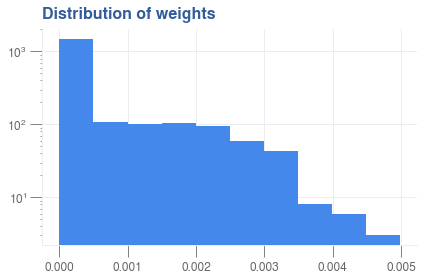

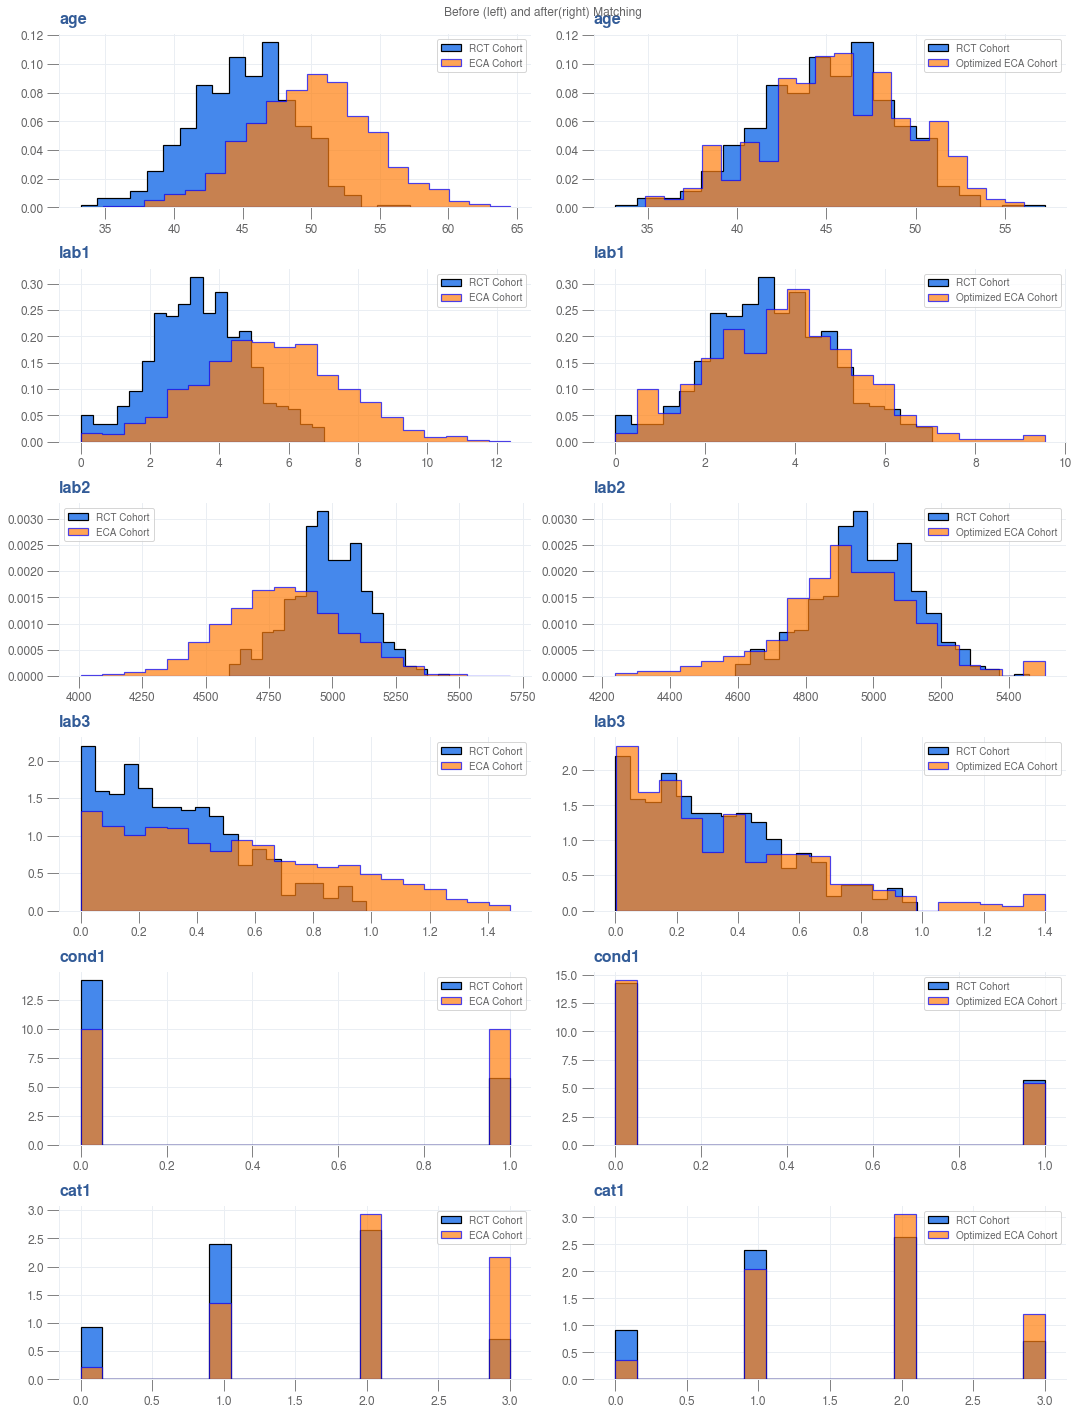

In [13]:
data_eca_study = genetic_matching(data_base, data_eca)

In [10]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', ks_2samp(data_base[col], data_eca[col]))
    print('After balancing', ks_2samp(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing KstestResult(statistic=0.4615, pvalue=1.2212453270876722e-15)
After balancing KstestResult(statistic=0.102, pvalue=0.010968966298223139)


Distribution of lab1
Before balancing KstestResult(statistic=0.459, pvalue=1.2212453270876722e-15)
After balancing KstestResult(statistic=0.11, pvalue=0.004686682589297701)


Distribution of lab2
Before balancing KstestResult(statistic=0.406, pvalue=1.2212453270876722e-15)
After balancing KstestResult(statistic=0.186, pvalue=5.6534932411175595e-08)


Distribution of lab3
Before balancing KstestResult(statistic=0.259, pvalue=1.2212453270876722e-15)
After balancing KstestResult(statistic=0.086, pvalue=0.04950261174890187)


Distribution of cond1
Before balancing KstestResult(statistic=0.2135, pvalue=1.2212453270876722e-15)
After balancing KstestResult(statistic=0.014, pvalue=0.9999999998936827)


Distribution of cat1
Before balancing KstestResult(statistic=0.2625, pvalue=1.2212453270876722e-15)
After balancing Kste

In [11]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', cohensd(data_base[col], data_eca[col]))
    print('After balancing', cohensd(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing -1.2072887363365403
After balancing -0.18460449201331947


Distribution of lab1
Before balancing -1.127079119575515
After balancing -0.1807599351241777


Distribution of lab2
Before balancing 0.8934273136316265
After balancing 0.31464657671400276


Distribution of lab3
Before balancing -0.6267566209648288
After balancing -0.140457191185468


Distribution of cond1
Before balancing -0.44759118866934916
After balancing 0.031150362222411618


Distribution of cat1
Before balancing -0.7026411298035246
After balancing -0.3578078178825893


